# Datawhale 零基础入门数据挖掘-Task3 特征工程¶

##  特征工程目标

Tip:此部分为零基础入门数据挖掘的 Task3 特征工程 部分，主要为各种特征工程以及分析方法。

**赛题：零基础入门数据挖掘 - 二手车交易价格预测**

地址：https://tianchi.aliyun.com/competition/entrance/231784/introduction?spm=5176.12281957.1004.1.38b02448ausjSX 

##  内容介绍
常见的特征工程包括：
1. 异常处理：
    - 通过箱线图（或 3-Sigma）分析删除异常值；
    - BOX-COX 转换（处理有偏分布）；
    - 长尾截断；
2. 特征归一化/标准化：
    - 标准化（转换为标准正态分布）；
    - 归一化（抓换到 [0,1] 区间）；
    - 针对幂律分布，可以采用公式： $log(\frac{1+x}{1+median})$
3. 数据分桶：
    - 等频分桶；
    - 等距分桶；
    - Best-KS 分桶（类似利用基尼指数进行二分类）；
    - 卡方分桶；
4. 缺失值处理：
    - 不处理（针对类似 XGBoost 等树模型）；
    - 删除（缺失数据太多）；
    - 插值补全，包括均值/中位数/众数/建模预测/多重插补/压缩感知补全/矩阵补全等；
    - 分箱，缺失值一个箱；
5. 特征构造：
    - 构造统计量特征，报告计数、求和、比例、标准差等；
    - 时间特征，包括相对时间和绝对时间，节假日，双休日等；
    - 地理信息，包括分箱，分布编码等方法；
    - 非线性变换，包括 log/ 平方/ 根号等；
    - 特征组合，特征交叉；
6. 特征筛选
    - 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择发/相关系数法/卡方检验法/互信息法；
    - 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper） ；
    - 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有 lasso 回归；
7. 降维
    - PCA/ LDA/ ICA；
    - 特征选择也是一种降维。



In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [2]:
path = './datalab/231784/'
train_load = pd.read_csv(path + 'used_car_train_20200313.csv', sep=' ')
test_load = pd.read_csv(path + 'used_car_testA_20200313.csv', sep=' ')
train_data, test_data = train_load.copy() , test_load.copy()
train_data.shape, test_data.shape

((150000, 31), (50000, 30))

In [3]:
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [4]:
train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [5]:
test_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,48587.000000,47107.000000,48090.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,174999.500000,68542.223280,2.003393e+07,46.844520,8.056240,1.782185,0.373405,0.224350,119.883620,12.595580,...,0.248669,0.045021,0.122744,0.057997,0.062000,-0.017855,-0.013742,-0.013554,-0.003147,0.001516
std,14433.901067,61052.808133,5.368870e+04,49.469548,7.819477,1.760736,0.546442,0.417158,185.097387,3.908979,...,0.044601,0.051766,0.195972,0.029211,0.035653,3.747985,3.231258,2.515962,1.286597,1.027360
min,150000.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.160049,-5.411964,-8.916949,-4.123333,-6.112667
25%,162499.750000,11203.500000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243762,0.000044,0.062644,0.035084,0.033714,-3.700121,-1.971325,-1.876703,-1.060428,-0.437920
50%,174999.500000,52248.500000,2.003091e+07,29.000000,6.000000,1.000000,0.000000,0.000000,109.000000,15.000000,...,0.257877,0.000815,0.095828,0.057084,0.058764,1.613212,-0.355843,-0.142779,-0.035956,0.138799
75%,187499.250000,118856.500000,2.007110e+07,65.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265328,0.102025,0.125438,0.079077,0.087489,2.832708,1.262914,1.764335,0.941469,0.681163
max,199999.000000,196805.000000,2.015121e+07,246.000000,39.000000,7.000000,6.000000,1.000000,20000.000000,15.000000,...,0.291618,0.153265,1.358813,0.156355,0.214775,12.338872,18.856218,12.950498,5.913273,2.624622


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

## 异常值处理
下面是一个包装好的异常值处理的代码。

In [7]:
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


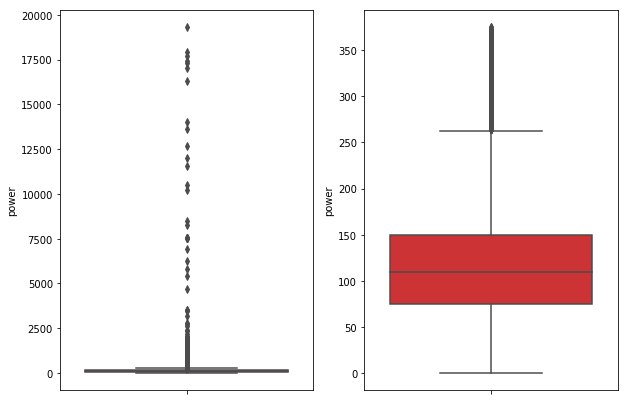

In [8]:
train_data = outliers_proc(train_data, 'power', scale=3) # 只能删除train_data中的异常值, 若数据多可能替换成nan更好

In [9]:
# 删除model为空的一行
train_data.drop(index=train_data.index[train_data['model'].isnull()], inplace=True)
train_data.shape

(149036, 31)

In [10]:
# 测试集没有bodyType缺失，bodyType缺失的的许多都含有其他缺失值，这里删除bodyType缺失的数据，约占总训练数据3%，也可以考虑不删除。 
train_data.drop(index=train_data.index[train_data['bodyType'].isnull()], inplace=True)
train_data.shape

(144542, 31)

## 构造特征
合并训练集和测试集，并构造特征。

In [11]:
train_data['istrain'] = 1
test_data['istrain'] = 0
train_labels = train_data['price']
data = pd.concat([train_data, test_data], ignore_index=True) # 合并train data, test data, 可一次性处理数据
data.drop(columns=['name', 'offerType', 'seller'], inplace=True) # 删除意义不大的特征
date_features = ['regDate', 'creatDate'] # 日期特征
cat_features = ['SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox', 'model', 'notRepairedDamage',  'regionCode'] # 类别特征
num_features = ['power', 'kilometer'] + ['v_' + str(i) for i in range(15)] 
cat_to_expand = ['bodyType', 'brand', 'fuelType', 'gearbox', 'model', 'notRepairedDamage'] # 需要统计数据扩展的特征
data.shape, data.columns

((194542, 29),
 Index(['SaleID', 'bodyType', 'brand', 'creatDate', 'fuelType', 'gearbox',
        'istrain', 'kilometer', 'model', 'notRepairedDamage', 'power', 'price',
        'regDate', 'regionCode', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13',
        'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9'],
       dtype='object'))

In [12]:
# power 分桶
bin = [i * 20 for i in range(-1, 20)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,3.0,60
1,0.0,0
2,9.0,163
3,10.0,193
4,4.0,68


In [13]:
# 增加特征regionCode_0, 1, 可以使用前regionCode_expand_num位，暂不清楚多少位好。
regionCode_expand_num = 2 
for i in range(regionCode_expand_num):
    data['regionCode_' + str(i)] =  data['regionCode'] // 10 ** (3-i)
    cat_features.append('regionCode_' + str(i))
    cat_to_expand.append('regionCode_' + str(i))

In [14]:
# 将notRepairedeDamage中'-'替换为np.nan(树模型可以处理)，并将object类型转为float
data['notRepairedDamage'] = data['notRepairedDamage'].replace("-", np.nan).astype(np.float) 

In [15]:
data['regionCode'].head()

0    1046
1    4366
2    2806
3     434
4    6977
Name: regionCode, dtype: int64

In [16]:
# regDate中存在月份为0的现象，不能直接转换，将其改为1月
def date_proc(x):
    m = int(x[4:6])
    if m == 0:
        m = 1
    return x[:4] + '-' + str(m) + '-' + x[6:]


data['regDate'] = pd.to_datetime(data['regDate'].astype('str').apply(date_proc)) 
data['regDate' + '_year'] = data['regDate'].dt.year # 添加注册年份特征
cat_to_expand.append('regDate_year')
#data[f + '_month'] = data[f].dt.month
#data[f + '_day'] = data[f].dt.day
#data[f + '_dayofweek'] = data[f].dt.dayofweek

In [17]:
# 增加特征使用年份
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d')).dt.days / 365
cat_to_expand.append('used_time')

In [18]:
data['used_time'].isnull().sum() # 没有日期异常

0

有些特征组合后可能会有更好的效果，下面构造交叉特征。

In [19]:
def create_cross_feature(df, columns):
    """"
    在df中增加交叉特征并返会交叉特征列名
    param df: pd.Dataframe
    param columns: 构成交叉特征的多个列名组成的列表
    """
    cross_feature_name = "cross_" + '_'.join(list(map(str, columns))) 
    df[cross_feature_name] = df[columns].apply(tuple, axis=1).apply(lambda x: '_'.join(map(str, x)))
    return cross_feature_name


cross_columns = [['regDate_year', 'kilometer'], ['brand', 'bodyType'], ['brand', 'model']]
for columns in cross_columns:
    cat_to_expand.append(create_cross_feature(data, columns))

In [20]:
cat_to_expand

['bodyType',
 'brand',
 'fuelType',
 'gearbox',
 'model',
 'notRepairedDamage',
 'regionCode_0',
 'regionCode_1',
 'regDate_year',
 'used_time',
 'cross_regDate_year_kilometer',
 'cross_brand_bodyType',
 'cross_brand_model']

In [21]:
# 下面是一个增加类别特的统计特征的函数

In [22]:
def cat_stat_expand(train_data, data, columns):
    """
    使用统计数据进行扩展， 这里没有inplace, 可尝试改为inplace
    param train_data: 用于生成统计数据的df
    param data: 需要扩展的df
    param columns： 需要使用统计数据扩展的列
    """
    for col in columns:
        train_gb = train_data.groupby(col)
        all_info = {}
        for kind, kind_data in train_gb:
            info = {}
            #kind_data = kind_data[kind_data['price'] > 0]
            #info[col + 'amount'] = len(kind_data) waste
            info[col + '_price_max'] = kind_data.price.max()
            info[col + '_price_median'] = kind_data.price.median()
            info[col + '_price_min'] = kind_data.price.min()
            #info[col + 'price_sum'] = kind_data.price.sum() waste
            #info[col + 'price_std'] = kind_data.price.std() waste
            #info[col + '_brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2) 
            all_info[kind] = info
        col_fea = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": col})
        data = data.merge(col_fea, how='left', on=col)
    return data 

In [23]:
data.columns

Index(['SaleID', 'bodyType', 'brand', 'creatDate', 'fuelType', 'gearbox',
       'istrain', 'kilometer', 'model', 'notRepairedDamage', 'power', 'price',
       'regDate', 'regionCode', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9',
       'power_bin', 'regionCode_0', 'regionCode_1', 'regDate_year',
       'used_time', 'cross_regDate_year_kilometer', 'cross_brand_bodyType',
       'cross_brand_model'],
      dtype='object')

In [24]:
data = cat_stat_expand(data[data['istrain']==1], data, cat_to_expand) # 特征扩展

In [35]:
# 这份数据已经可供树模型使用
data.to_csv('data_for_tree.csv', index=0)

## 3. 特征筛选

### 1) 过滤式

In [33]:
# 相关性分析
print(data['kilometer'].corr(data['price'], method='spearman'))

-0.4225877951042517


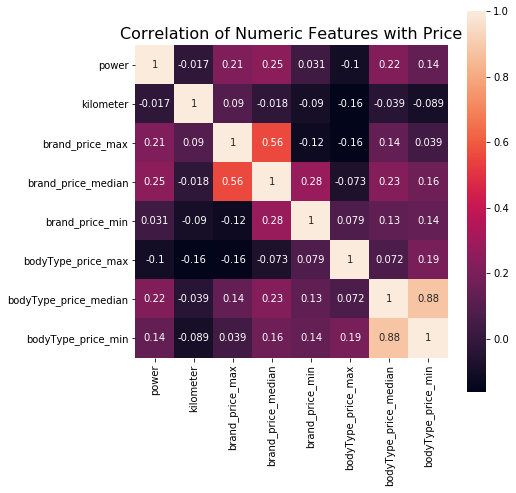

In [32]:
# 挑选了部分特征绘制heatmap, 可以看出bodyTpe_median是一个很重要的特征
data_numeric = data[['power', 'kilometer',  'brand_price_max', 'brand_price_median', 'brand_price_min',
                     'bodyType_price_max',  'bodyType_price_median', 'bodyType_price_min']]
correlation = data_numeric.corr()
f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  annot=True)

### 2) 包裹式

In [45]:
# k_feature 太大会很难跑
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)

data.dropna(how="any", inplace=True)
data = data[[col for col in data.columns if col not in date_features]]
data = data[[col for col in data.columns if data[col].dtype != tuple]]
x = data.drop(['price'], axis=1)
x = x.fillna(0)
y = data['price']
sfs.fit(x, y)
sfs.k_feature_names_ 

('kilometer',
 'power',
 'v_12',
 'v_14',
 'used_time',
 'used_time_price_max',
 'used_time_price_median',
 'cross_regDate_year_kilometer_price_median',
 'cross_brand_bodyType_price_median',
 'cross_brand_model_price_median')

### 3) 嵌入式

见Task4, Lasso 回归和决策树可以完成嵌入式特征选择
大部分情况下都是用嵌入式做特征筛选